# Cartopy Tutorial

Nathan Wendt ([email](mailto:nathan.wendt@noaa.gov))  
Meteorologist  
[NWS SPC](http://spc.noaa.gov)


This is a tutorial for the [cartopy](http://scitools.org.uk/cartopy/) map plotting package for Python. To run this notebook, I recommend using a [miniconda](https://conda.io/miniconda.html) installation and installing the required packages into their own environment. Cartopy is available on the scitools channel and metpy is available on the unidata channel. Both, however, are available on the conda-forge channel.

### Imports

In [1]:
import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import fiona
from shapely.geometry import shape, MultiPolygon
import matplotlib.patches as mpatches
from metpy.calc import wind_components
from metpy.plots import StationPlot
import json

### Conversions/Constants/Functions

In [2]:
MSTOKTS = 1.94384

In [3]:
TPROBCOLORS = ['purple', 'magenta', 'red', 'yellow', 'brown', 'green']
TPRLABELS = ['2%', '5%', '10%', '15%', '30%', '45%']
EXTENT = [-105,-90,30,45]
STN_EXTENT = [-105,30,-90,45]

In [4]:
def KTOF(T):
    return T * (9/5.) - 459.67

### Data

Some of the data we will be using is from the RUC numerical weather predication model. The data are from the 2100 UTC analysis on April 14, 2012. We also will make use of surface station data obtained from the [MesoWest API](http://synopticlabs.org/api/) for several stations at the observation time closest to 2100 UTC. The surface station data has been preprocessed to be in the correct format for plotting using MetPy. A tutorial on the MesoWest API and MetPy will have to wait until another time. Lastly,we also have some satellite data from GOES-13 obtained via [NOAA CLASS](http://www.class.noaa.gov/). The full CONUS data has been trimmed down to the area of interest in the Central Plains of the US to avoid large data size.

In [5]:
ruc = np.load('ruc2anl_130_20120414_2100_000.npz')
stn_data = np.load('20120414_mesowest_stn.npz')
sat = np.load('20120414_g13_vis.npz')

##### Projection

Model calculations are done on a Lambert Conformal Conic (LCC) grid. The coordinates are given to us in latitude an longitude, but we will have to use the proper projection parameters to do most plots. Below are the proper parameters for the RUC model. The dictionary key names have been chose so that they can be easily expanded into the cartopy methods. Other projections may have other keywords to deal with.

**Note:** Longitude can be $\ge$ 180$^\circ$. Cartopy will account for this automatically.

In [6]:
lccProjParams = { 'central_latitude'   : 25.0, # same as lat_0 in proj4 string 
                  'central_longitude'  : 265.0, # same as lon_0
                  'standard_parallels' : (25.0, 25.0) # same as (lat_1, lat_2)
}

##### Fields|

In [7]:
### RUC
# surface fields
sfcT = ruc['TSFC']
sfcP = ruc['PSFC']/100 # in hPa
sfcTf = KTOF(sfcT) # in F
sfcTd = ruc['TDSFC']
sfcTdf = KTOF(sfcTd) # in F
MSLP = ruc['MSLP']/100 # in hPa
sfcU = ruc['USFC']
sfcV = ruc['VSFC']

# 500 mb fields
h5T = ruc['T500']
h5Ht = ruc['HGHT500']
h5U = ruc['U500']
h5V = ruc['V500']
h5RelV = ruc['ABSV500']

# coordinates
lat = ruc['LAT']
lon = ruc['LON']

### SURFACE STATIONS
stn_lon = stn_data['longitude']
stn_lat = stn_data['latitude']
stn_u = stn_data['eastward_wind']
stn_v = stn_data['northward_wind']
stn_Td = stn_data['dew_point']
stn_T = stn_data['air_temperature']
stn_slp = stn_data['slp']

### GOES-13 SATELITE
sat_gvar = sat['gvar10']
sat_lat = sat['lat']
sat_lon = sat['lon']

### Plotting

##### Colormaps

Let's make some custom colormaps so that the data are much easier to interpret.

In [8]:
VORT_COLORS = [(0.231, 0.231, 0.231, 1.0),
 (0.3164444444444445, 0.3164444444444445, 0.3164444444444445, 1.0),
 (0.4018888888888889, 0.4018888888888889, 0.4018888888888889, 1.0),
 (0.4873333333333333, 0.4873333333333333, 0.4873333333333333, 1.0),
 (0.5727777777777778, 0.5727777777777778, 0.5727777777777778, 1.0),
 (0.6582222222222223, 0.6582222222222223, 0.6582222222222223, 1.0),
 (0.7436666666666666, 0.7436666666666666, 0.7436666666666666, 1.0),
 (0.829111111111111, 0.829111111111111, 0.829111111111111, 1.0),
 (0.9145555555555556, 0.9145555555555556, 0.9145555555555556, 1.0),
 (1.0, 1.0, 1.0, 1.0),
 (0.0, 0.902, 0.843, 1.0),
 (0.0785, 0.8825000000000001, 0.5, 1.0),
 (0.157, 0.863, 0.157, 1.0),
 (0.471, 0.941, 0.157, 1.0),
 (0.6276666666666666, 0.941, 0.10466666666666667, 1.0),
 (0.7843333333333333, 0.941, 0.05233333333333334, 1.0),
 (0.941, 0.941, 0.0, 1.0),
 (0.941, 0.745, 0.0, 1.0),
 (0.8645, 0.3725, 0.0, 1.0),
 (0.788, 0.0, 0.0, 1.0),
 (0.882, 0.0, 0.0, 1.0),
 (0.9213333333333333, 0.24066666666666664, 0.3333333333333333, 1.0),
 (0.9606666666666667, 0.4813333333333333, 0.6666666666666666, 1.0),
 (1.0, 0.722, 1.0, 1.0)]

VORT_LEVELS = np.arange(-40,85,5)
VORT_CMAP = colors.ListedColormap(VORT_COLORS)
VORT_CMAP.set_over('white')
VORT_NORM = colors.BoundaryNorm(VORT_LEVELS, VORT_CMAP.N)
VORT_CBTIX = np.arange(-40, 90, 10)

In [9]:
SFCT_LEVELS = np.array([-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110])
SFCT_COLORS = [
    (.996,.824,.996), (1.,.714,1.), (.969,.553,.969), (.894,.353,.949),
    (.588,.118,.941), (.341,0.,.941), (.137,.388, .941), (.031,.698,.918),
    (0.,.784,1.), (0.,.902,.843), (.157,.863,.157), (.078,.902,.392),
    (.471,.941,.157), (.784,.941,.078), (.941,.941,0.), (.941,.745,0.),
    (.941,.51,0.), (.941,.314,0.), (.882,.157,0.), (.784,0.,0.), (.682,0.,0.),
    (.882,.22,.482), (.882,.404,.667), (.969,.553,.969), (1.,.714,1.), (.996,.824,.996),
]
SFCT_CMAP = colors.ListedColormap(SFCT_COLORS)
SFCT_CMAP.set_over((1,1,1))
SFCT_CMAP.set_under((1,1,1))
SFCT_NORM = colors.BoundaryNorm(SFCT_LEVELS, SFCT_CMAP.N)
SFCT_CBTIX = np.arange(-20, 120, 10)

In [10]:
segment1 = colors.LinearSegmentedColormap.from_list('dewpt1', [(.541,.396,.286), (.286,.255,.212), (.592,.569,.498), (1,1,1)], 30)
segment2 = colors.LinearSegmentedColormap.from_list('dewpt2', [(.894,.961,.894), (.035,.298,.035)], 10)
segment3 = colors.LinearSegmentedColormap.from_list('dewpt3', [(.38,.639,.686), (.075,.169,.165)], 5)
segment4 = colors.LinearSegmentedColormap.from_list('dewpt4', [(.404,.42,.612), (.169,.141,.404)], 5)

DEWPT_LEVELS = np.arange(-20,82,2)
DEWPT_COLORS = np.asarray([ segment1(x) for x in np.linspace(0.,1.,segment1.N) ] +
                          [ segment2(x) for x in np.linspace(0.,1.,segment2.N) ] +
                          [ segment3(x) for x in np.linspace(0.,1.,segment3.N) ] +
                          [ segment4(x) for x in np.linspace(0.,1.,segment4.N) ])

DEWPT_CMAP = colors.ListedColormap(DEWPT_COLORS)
DEWPT_CMAP.set_over((.471,.282,.439))
DEWPT_CBTIX = np.arange(-20,90,10)
DEWPT_NORM = colors.BoundaryNorm(DEWPT_LEVELS, DEWPT_CMAP.N)

##### Procedure

The first critical piece for plotting with cartopy is to know what type of coordinates your data are. Are your coordinates in *geographic* coordinates or *projected* coordinates? For a primer on what both types are look [here](http://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/what-are-map-projections.htm#GUID-B04B5F47-3FA9-40C3-9DDA-834AD2E0E6AF) This is a common source of confusion. When we grab numerical weather model data, we usually have an idea about what projection it is in. For the NCEP suite of models, LCC is by far the most common. The confusion comes from thinking that the raw ouput coordinates are already in LCC. However, generally speaking, the coordiantes you extract from the model are simply latitude and longitude. This puts them in the *geographic* coordinate system. The mistake that can be made here is to treat the latitude and longitude points as *projected* coordinates.

The first object we need to create is the `crs` object. This object will be used to tell cartopy what projection that data will be **displayed** in.

In [11]:
proj = ccrs.LambertConformal(**lccProjParams)

The next part shows us how easy cartopy makes it to plot our data. Cartopy has simply overridden some of the matplotlib plotting methods to include special keywords that allow cartopy to handle the spatial data and shapefiles properly.

There are two things that are critical in the code snipped below:

  1. The `projection` keyword when creating the `axes` object.
  2. The `transform` keyword when calling your plot method (in this case `pcolormesh`)

When creating an `axes`, the `projection` keyword is where you want to put the `crs` object that describes how you want your data to look when it gets plotted. Think of it as the *destination* projection. The `transform` keyword in the plot call tells cartopy what type of *source* coordinates you have. In this case there are raw latitude and longitude points so we use `PlateCarree`. `PlateCarree` will take our coordinates and *project* them into grid or projected coordinates. They will then have units in meters instead of degrees. If the LCC `crs` object would have been used in `transform`, the coordinates would be assumed to already be projected and in meters. What happens if you give latitude and longitude and it expects a projected point in meters is the plot will be drawn, but the extent will be so small you will not see it on the map.

The other nice feature of cartopy is its seamless interface with [Natural Earth](http://www.naturalearthdata.com/) shapefile data. As long as you know something about what Natural Earth has to offer, you can easily download it and plot by passing a `NaturalEarthFeature` object to the `add_feature` method. Of course, you can plot shapefiles you already have, you will just have to pass a different `feature` object to `add_feature`.

When plotting things like wind vectors, it is desirable to avoid plotting at every point. Fortunately, cartopy has a keyword, `regrid_shape`, that will help you thin out the data and avoid overplotting. This is much better than thinning the data yourself as cartopy is then able to change the extent such that bars/vectors do not stick as far off the edge of the plot. Think of this value as a density. The higher the number, the more vectors will be plotted.

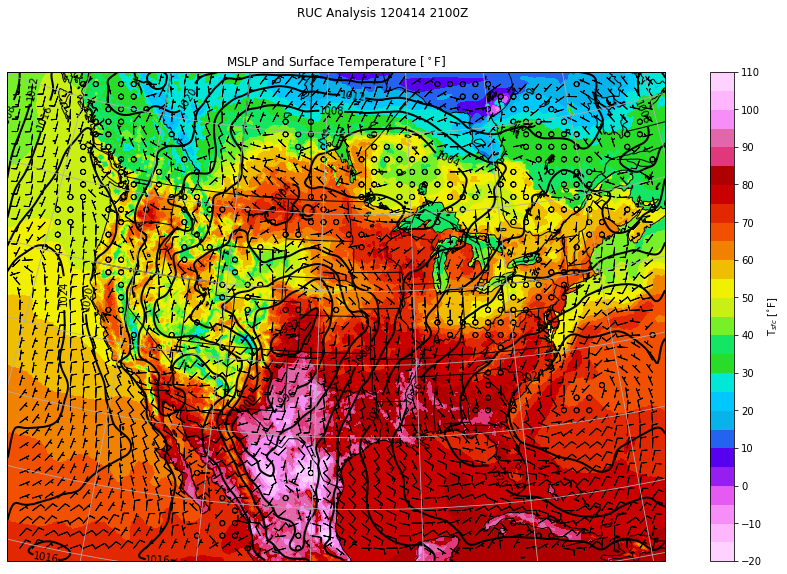

In [12]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection=proj)
cbax = ax.contourf(lon, lat, sfcTf, transform=ccrs.PlateCarree(), levels=SFCT_LEVELS, 
                   cmap=SFCT_CMAP, norm=SFCT_NORM)
ax.barbs(lon, lat, sfcU, sfcV, length=4.5,
         sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
         linewidth=0.95, transform=ccrs.PlateCarree(),
         regrid_shape = 40)
ctax = ax.contour(lon, lat, MSLP, levels = np.arange(980, 1044, 4), 
                  colors = 'k', transform = ccrs.PlateCarree(),
                  linewidths = 2)
plt.clabel(ctax, inline = True, fmt = '%4d')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
ax.gridlines()
save_extent = ax.get_extent(crs=ccrs.PlateCarree())

plt.title('MSLP and Surface Temperature [$^\circ$F]')
plt.suptitle('RUC Analysis 120414 2100Z')
cb = plt.colorbar(cbax, ax = ax, label = 'T$_{sfc}$ [$^{\circ}$F]')
cb.set_ticks(SFCT_CBTIX)
plt.show()

And a streamplot with surface dewpoints...

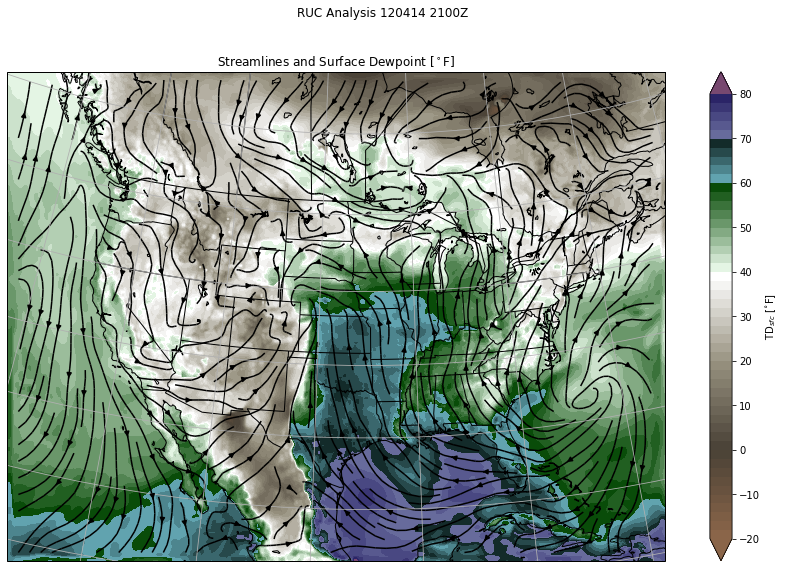

In [13]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection=proj)
cbax = ax.contourf(lon, lat, sfcTdf, transform = ccrs.PlateCarree(), 
                     cmap=DEWPT_CMAP, norm=DEWPT_NORM, levels=DEWPT_LEVELS, extend='both')
ax.streamplot(lon, lat, sfcU, sfcV, transform = ccrs.PlateCarree(),
              linewidth = 1.5, density = 2, color = 'k')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
ax.gridlines()
plt.title('Streamlines and Surface Dewpoint [$^\circ$F]')
plt.suptitle('RUC Analysis 120414 2100Z')
cb = plt.colorbar(cbax, ax = ax, label = 'TD$_{sfc}$ [$^{\circ}$F]')
cb.set_ticks(DEWPT_CBTIX)
plt.show()

And upper-level features...

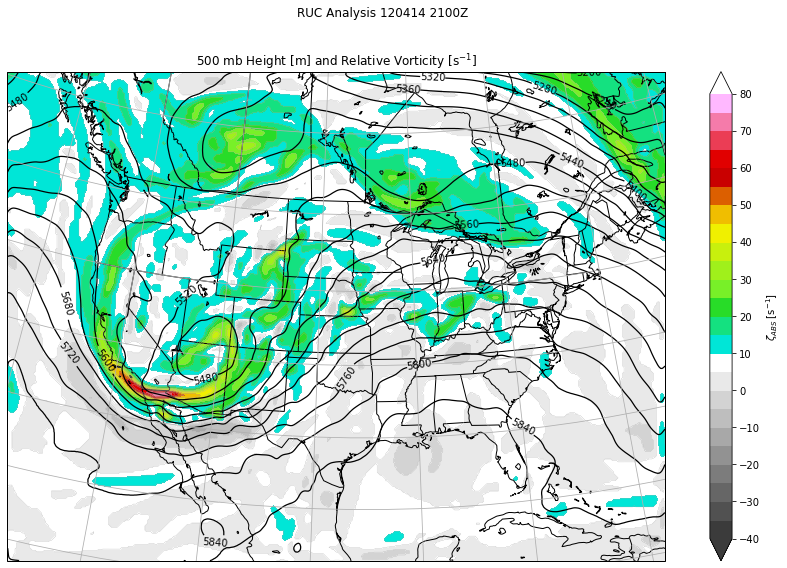

In [14]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection = proj)
cbax = ax.contourf(lon, lat, h5RelV/1e-5, transform = ccrs.PlateCarree(), # what are the input coordinates?
                     cmap = VORT_CMAP, levels=VORT_LEVELS, extend='both')
ax.contour(lon, lat, h5RelV/1e-5, transform = ccrs.PlateCarree(), # what are the input coordinates?
           levels=VORT_LEVELS, linewidths=0.3, colors='darkgray')
ctax = ax.contour(lon, lat, h5Ht, levels = np.arange(4960, 5960, 40), 
                  colors = 'k', transform = ccrs.PlateCarree(),
                  linewidths = 1.25)
plt.clabel(ctax, inline = True, fmt = '%4d')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
ax.gridlines()

plt.title('500 mb Height [m] and Relative Vorticity [s$^{-1}$]')
plt.suptitle('RUC Analysis 120414 2100Z')
cb = plt.colorbar(cbax, ax = ax, label = '$\zeta_{ABS}$ [s$^{-1}$]')
cb.set_ticks(VORT_CBTIX)
plt.show()

What about plotting in a different projection? Just change `projection` in the `axes` object.

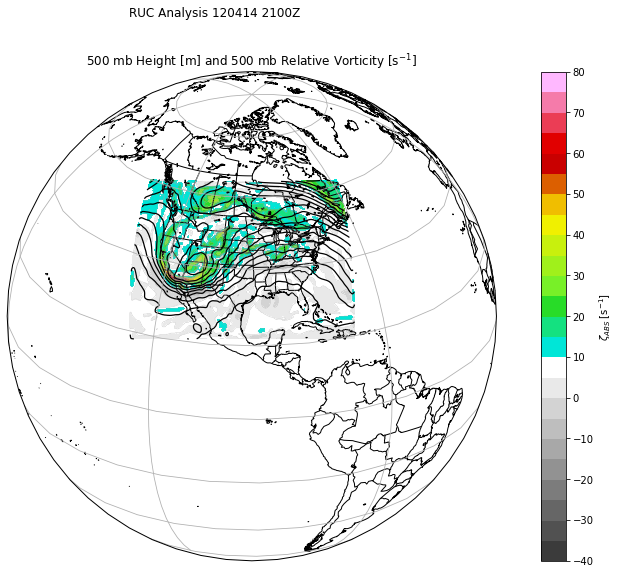

In [15]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection = ccrs.Orthographic(central_latitude = 25, central_longitude = 265)) # this is the new projection
cbax = ax.contourf(lon, lat, h5RelV/1e-5, transform = ccrs.PlateCarree(), # what are the input coordinates?
                     cmap = VORT_CMAP, levels=VORT_LEVELS)
ax.contour(lon, lat, h5RelV/1e-5, transform = ccrs.PlateCarree(), # what are the input coordinates?
           levels=VORT_LEVELS, linewidths=0.3, colors='darkgray')
ax.contour(lon, lat, h5Ht, levels = np.arange(4960, 5960, 40), 
                  colors = 'k', transform = ccrs.PlateCarree(),
                  linewidths = 1.25)
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
ax.gridlines()
ax.set_global() # show full extent just for fun
plt.title('500 mb Height [m] and 500 mb Relative Vorticity [s$^{-1}$]')
plt.suptitle('RUC Analysis 120414 2100Z')
cb = plt.colorbar(cbax, ax = ax, label = '$\zeta_{ABS}$ [s$^{-1}$]')
cb.set_ticks(VORT_CBTIX)
plt.show()

#### Using Shapefiles

While cartopy does have its own shapfile reading methods, fiona offers a superior experience. shapely offers lots of methods to manipulate shapefiles and cartopy has its own methods that integrate well with shapely objects.

In [16]:
shp = fiona.open('day1otlk_20120414_1630_torn.shp', 'r')

Shapefiles have their own CRS information that we will need to extract. As with the data example earlier, cartopy needs to know what projection the shapefile is in. If you are not sure of what it is, you can get it from the opened fiona object.

In [17]:
# what is the CRS?
shp.crs

{'proj': 'lcc',
 'lat_0': 0,
 'lon_0': 0,
 'lat_1': 33,
 'lat_2': 45,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

This shape file is in LCC, but some of the parameters are different than what was being plotted earlier. Put this information into a cartopy `crs` object.

In [18]:
shpProj = ccrs.LambertConformal(central_latitude = shp.crs['lat_0'],
                                central_longitude = shp.crs['lon_0'], 
                                standard_parallels = (shp.crs['lat_1'], shp.crs['lat_2']))

A straight-forward way to then plot the shapefile on a map is to pass a `ShapelyFeature` object to the `add_feature` method (the `add_geometries` method also works similarly). What this means is that the shapefile data needs to be in a shapely object. When fiona reads in the shapefile, it provides a GeoJSON-like interface to the data. The data will have to be extracted from this format and input into a shapely `Polygon` first. To do that, we can use the `shape` method and pass it the geometry information out of the shapefile. From there, if there are more than one `Polygon` object in the shapefile, it will then be easiest to deal with in the shapely `MultiPolygon` format. All of this can be accomplished in one line by using list comprehension as is done below.

In [19]:
mp = MultiPolygon([shape(polygon['geometry']) for polygon in shp])

To plot the shapefile on a map, it works much the same as before. The biggest difference is that you do not call a typical plotting routine, but something like `add_feature` or `add_geometries`. Because all the polygons in the shapefile have been combined into one `MultiPolygon`, all the plotting can be handled at once. Of course, you could also write a loop to plot each `Polygon` separately and give yourself finer control over some of the options. As before, be careful of what your input projection (from the shapefile) and plotting projection are.

Due to some matplotlib quirks, having a legend automatically created from the colored polygons does not work. Using `patches` and `lines` from matplotlib will work to get the legend working.

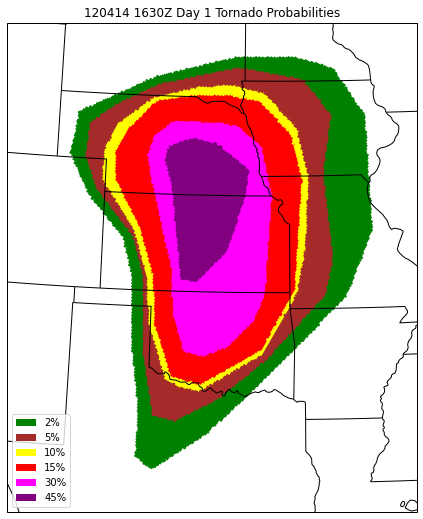

In [20]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection = proj)
ax.add_feature(feature.ShapelyFeature(mp, shpProj), facecolor = TPROBCOLORS, 
               edgecolor = TPROBCOLORS)
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
ax.set_extent(EXTENT, ccrs.PlateCarree())
ax.set_title('120414 1630Z Day 1 Tornado Probabilities')

# rectangular colorfill patches for legend
tor2 = mpatches.Rectangle((0,0), 1, 1, ec = 'none', fc = TPROBCOLORS[5], lw=2)
tor5 = mpatches.Rectangle((0,0), 1, 1, ec = 'none', fc = TPROBCOLORS[4], lw=2)
tor10 = mpatches.Rectangle((0,0), 1, 1, ec = 'none', fc = TPROBCOLORS[3], lw=2)
tor15 = mpatches.Rectangle((0,0), 1, 1, ec = 'none', fc = TPROBCOLORS[2], lw=2)
tor30 = mpatches.Rectangle((0,0), 1, 1, ec = 'none', fc = TPROBCOLORS[1], lw=2)
tor45 = mpatches.Rectangle((0,0), 1, 1, ec = 'none', fc = TPROBCOLORS[0], lw=2)

rects = [tor2, tor5, tor10, tor15, tor30, tor45]

leg = ax.legend(rects, TPRLABELS, loc = 3)
plt.show()

#### Using GeoJSON

As of 10/17/2019, the SPC began to produce GeoJSON files of our convective outlook products. The benefits of this format is twofold:

1. The resulting graphics will look smooth and be rendered just as they were drawn by an SPC forecaster. The shapefiles, seen above, produce jagged looking edges.
2. In order to accomplish this, the outlook lines must be put through an extra QC process so that all lines are closed and valid polygons. Shapefiles may contain irregularities that cause plotting software to improperly render the shape (e.g., the color fill is placed outside the shape)

As with shapefiles, we can fairly easily handle importing GeoJSON data and making plots with cartopy. In fact, because of some useful metadata that has been put in the GeoJSONs, plotting is even a bit easier.

In [21]:
outlook =  json.load(open('day1otlk_20200412_1630_cat.lyr.geojson', 'rb'))
features = outlook['features']

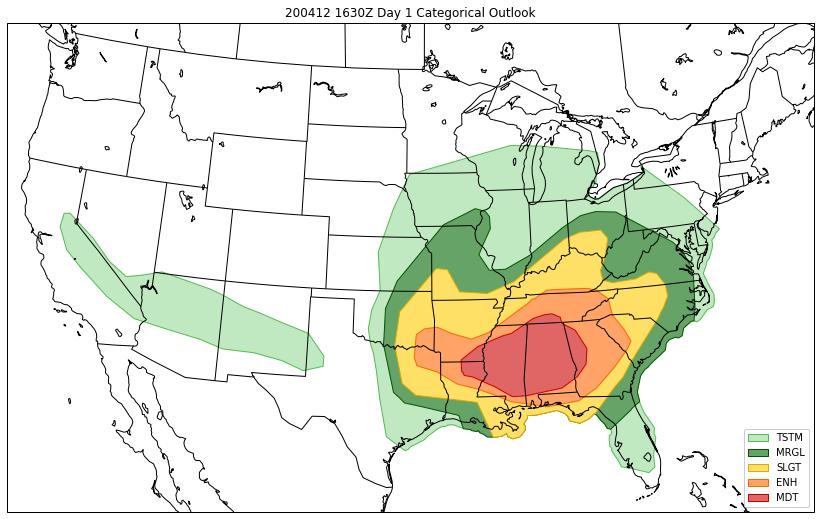

In [22]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection = proj)
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.set_title('200412 1630Z Day 1 Categorical Outlook')
ax.add_feature(feature.BORDERS)
ax.set_extent((-121,-71,22.5,49))

otlk_legend = []
legend_labels = []
for feat in features:
    # The nice metadata included in the GeoJSONs helps us with the colors and the legend
    face = feat['properties']['fill']
    edge = feat['properties']['stroke']
    geom = shape(feat['geometry'])
    label = feat['properties']['LABEL']
    otlk_legend.append(mpatches.Rectangle((0,0), 1, 1, ec = edge, fc = face, lw=1))
    legend_labels.append(label)
    ax.add_feature(feature.ShapelyFeature(geom, ccrs.PlateCarree()),
                   facecolor=face, edgecolor=edge, label=label, zorder=0)

leg = ax.legend(otlk_legend, legend_labels, loc=4, framealpha=1)
plt.show()

#### Surface Stations Overlayed on Satellite

The surface station plot requires use of [MetPy](https://unidata.github.io/MetPy/). As stated before, the process of downloading the data and getting it into the right format has been done already. This is just to show what can be done using cartopy.

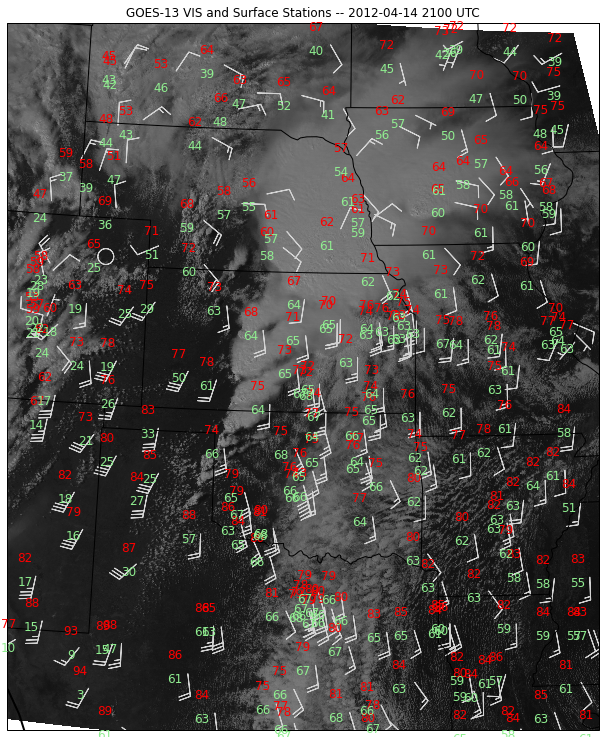

In [23]:
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines(resolution='50m', zorder=2, color='black')
ax.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m', facecolor='none', edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(category='physical',
                                           name='lakes',
                                           scale='50m',
                                           facecolor='none'))
ax.add_feature(feature.BORDERS, linewidth=2, edgecolor='black')

stationplot = StationPlot(ax, stn_lon, stn_lat,
                          transform=ccrs.PlateCarree(), fontsize=12)

stationplot.plot_parameter('NW', stn_T, color='red')
stationplot.plot_parameter('SW', stn_Td, color='lightgreen')
# skipping SLP for aesthetics
# stationplot.plot_parameter('NE', stn_slp,
#                            formatter=lambda v: format(10 * v, '.0f')[-3:], color = 'yellow')
stationplot.plot_barb(stn_u, stn_v, color = 'lightgray')

# Satellite data
ax.pcolormesh(sat_lon, sat_lat, sat_gvar, 
                     transform = ccrs.PlateCarree(),
                     cmap = cm.gray, vmin = 0, vmax = 1023, zorder = 0) # Note zorder
ax.set_extent(EXTENT, ccrs.PlateCarree())
plt.title('GOES-13 VIS and Surface Stations -- 2012-04-14 2100 UTC')
plt.show()